## 1. Install dependences and load data

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr
import matplotlib
from PIL import Image
import keras-tuner

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Avoid OutOfMemory error | I do not have a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[]


In [ ]:
# Get all attributes of image_dataset_from_directory
tf.keras.utils.image_dataset_from_directory??

In [ ]:
# Define the paths to the train and test directories
train_dir = '/content/drive/MyDrive/ml_project/data/train'
test_dir = '/content/drive/MyDrive/ml_project/data/test'

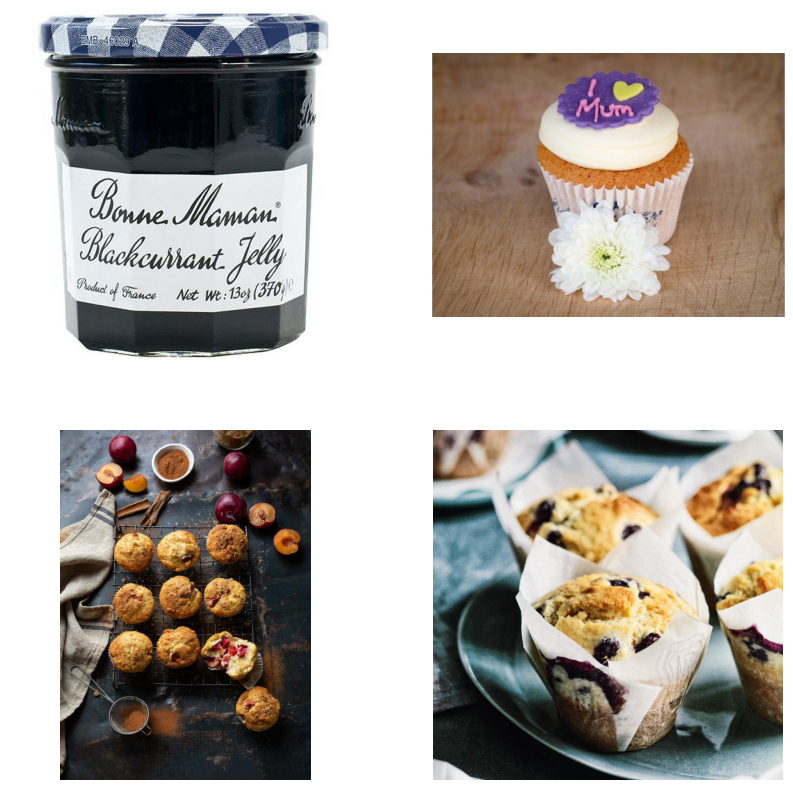

In [ ]:
# We visualize the images to get an idea of their structure / MUFFINS
images=[]
f, axarr = plt.subplots(2,2, figsize=(10,10))
im_index=0

for row in range(2):
    for column in range(2):
        path=os.path.join(train_dir,'muffin')
        images.append(cv2.imread(os.path.join(path,os.listdir(path)[im_index])))
        axarr[row,column].imshow(cv2.cvtColor(images[im_index], cv2.COLOR_BGR2RGB))
        im_index+=1
        axarr[row,column].axis("off")

plt.show()

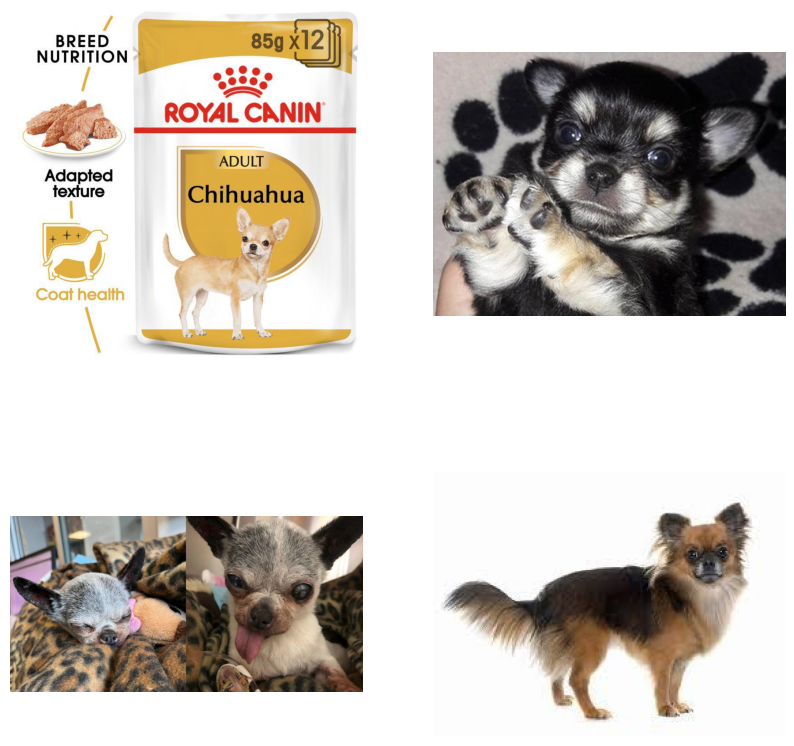

In [ ]:
# We visualize the images to get an idea of their structure / CHIHUAHUAS
images=[]
f, axarr = plt.subplots(2,2, figsize=(10,10))
im_index=0

for row in range(2):
    for column in range(2):
        path=os.path.join(train_dir,'chihuahua')
        images.append(cv2.imread(os.path.join(path,os.listdir(path)[im_index])))
        axarr[row,column].imshow(cv2.cvtColor(images[im_index], cv2.COLOR_BGR2RGB))
        im_index+=1
        axarr[row,column].axis("off")

plt.show()

In [ ]:
# with keras.utils we do not have to code the labels, and it preprocesses
## These build the data pipeline
train = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                    color_mode = 'grayscale',
                                                    image_size = (150,150)
                                                    )
test = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                   color_mode = 'grayscale',
                                                   image_size = (150,150)
                                                   )
# if I add color_mode = 'grayscale' pictures appear blue/yello, idk y

# train and test are NOT preloaded, they are generators.
# we first convert into a numpy iterator

Found 4733 files belonging to 2 classes.
Found 1194 files belonging to 2 classes.


In [ ]:
# with iterators we can access the generator from the data pipeline
## These allow to access the data pipeline
train_iterator = train.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [ ]:
# gets another batch from the iterator
## Accessing the data pipeline itself
train_batch = train_iterator.next()
test_batch = test_iterator.next() # is this even necessary??

In [ ]:
#the batches have len = 2, 1 is image representation, 2 is the label
print(len(train_batch))
train_batch[1] # dogs or muffins?

2


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
print(train_batch[0].shape)
# images represented as numpy arrays
# batch size is 32, last one (3) are the channels (rgb)
# if I put color_mode = 'grayscale' when using tf.keras.utile.image_from_dataset
# I get just one "channel", so last element of the tuple is 1.

(32, 150, 150, 1)


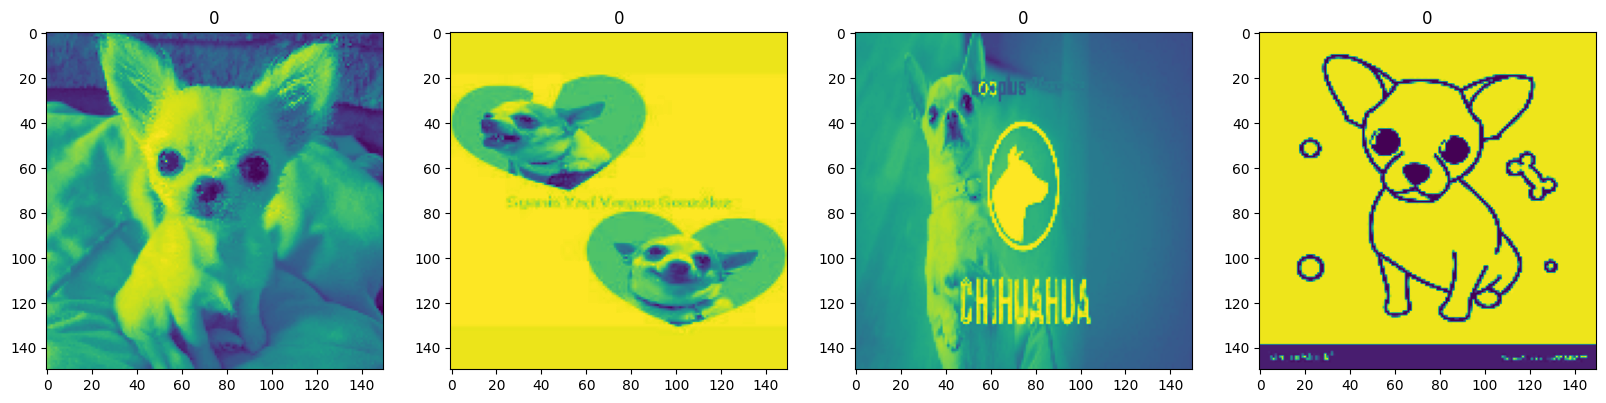

In [ ]:
# visualize the images. They have the correct colors!
# 1 is muffins, 0 is chihuahuas
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(train_batch[1][idx])

## Data Processing
- Resize all images -> already done
- Bring everything to greyscale -> already done

In [ ]:
# shape of each image
print(train_batch[0].shape)
print(train_batch[0].min())
print(train_batch[0].max()) # we want values as small as possible -> /255
# this makes optimization more efficient -> we need to scale values

(32, 150, 150, 1)
0.0
255.0


In [ ]:
# we implement the data transformation in the pipeline
# x represent images, y labels
train = train.map(lambda x,y: (x/255,y))
test = test.map(lambda x,y: (x/255,y))


In [ ]:
scaled_iterator = train.as_numpy_iterator()
scaled_iterator_test = test.as_numpy_iterator()

In [ ]:
train_batch = scaled_iterator.next()
test_batch = scaled_iterator_test.next()

In [ ]:
# check the values of the images
print(f"Min value of scaled images: {train_batch[0].min()}")
print(f"Max value of scaled images: {train_batch[0].max()}")

Min value of scaled images: 0.0
Max value of scaled images: 1.0


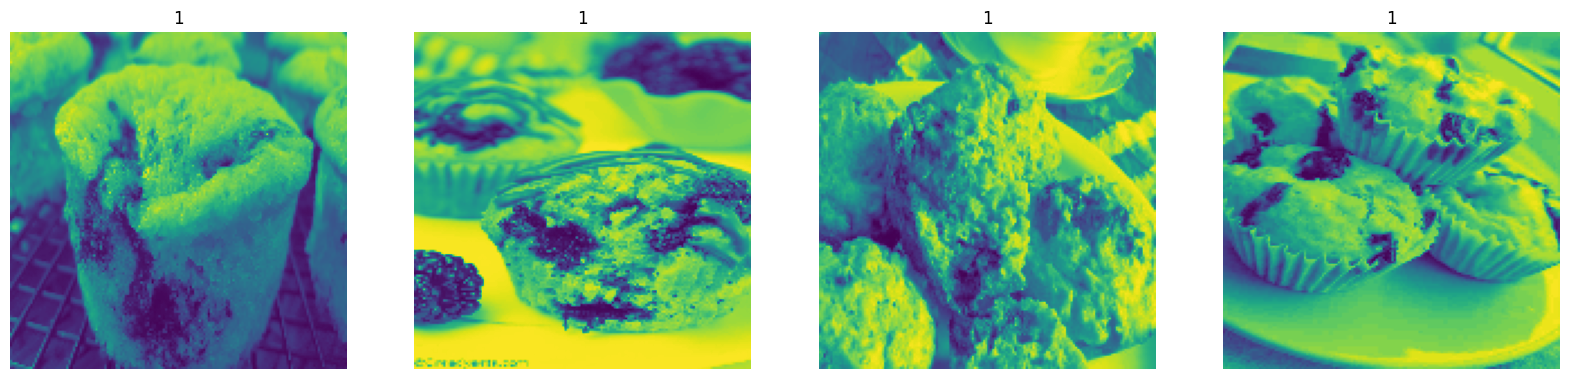

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img)  # Matplotlib uses default colormap
    ax[idx].axis('off')  # Turn off axis
    ax[idx].title.set_text(train_batch[1][idx])

plt.show()

## Create Validation Data
Maybe I should kip this and when I use the .fit method I just put a `validation_split` attribute..

In [ ]:
print(len(train)) # we have 148 batches
train_size = int(len(train)*0.8)
val_size = int(len(train)*0.2) + 1 # + 1 otherwise 1 is missing

print(train_size)
print(val_size)

148
118
30


In [ ]:
train_data = train.take(train_size)
val_data = train.skip(train_size).take(val_size)

In [ ]:
print(f"len(train) = {len(train_data)}")
print(f"len(val) = {len(val_data)}")
print(f"Length of initial data = {len(train)} = {len(train_data) + len(val_data)}")

len(train) = 118
len(val) = 30
Length of initial data = 148 = 148


## Build the Model

In [ ]:
from tensorflow.keras.models import Sequential # good with 1 input 1 output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
# initialize the first model
model0 = Sequential()

# First layer must be input layer or have an input
model0.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(150, 150, 1)))  # Change channels from 1 to 3 if using RGB instead of grayscale
# 16 is the number of filters, each filter is 3x3 pixels, 1 is the stride
model0.add(MaxPooling2D())
# This takes the maximum value after the ReLU and returns it
# Check MaxPooling2D?? for each 2x2 region (pool) takes the highest value

model0.add(Conv2D(32, (3, 3), 1, activation='relu'))  # Now 32 filters
model0.add(MaxPooling2D())

model0.add(Conv2D(16, (3, 3), 1, activation='relu'))
model0.add(MaxPooling2D())

model0.add(Flatten())
# When we apply the conv layer, the filters are going to be the last channel.
# We condense the length and width, then the number of filters will form the
# channel value. When we pass values to the dense layer, we don't want multiple
# values, but we want to 'flatten' them into a single value (thus the Flatten layer).

# Dense layers are fully connected layers
model0.add(Dense(256, activation='relu'))  # 256 values as output
model0.add(Dense(1, activation='sigmoid'))  # 1 output only, due to sigmoid

model0.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# we use binary cross entropy since it is a classification problem.
#tf.optimizers. to get all the optimizers

model0.summary()

## Train the model

In [ ]:
# create a log directory
logdir = 'logs'

In [ ]:
# this is going to log how the model trains as it trains
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
#.fit method -> training component
#.predict -> when we make the predictions
hist0 = model0.fit(train_data,
                 epochs=20,
                 validation_data = val_data,
                 callbacks=[tensorboard_callback])

# This takes too long..

Epoch 1/20
118/118 [==============================] - 126s 1s/step - loss: 0.5435 - accuracy: 0.7312 - val_loss: 0.4665 - val_accuracy: 0.7879
Epoch 2/20
118/118 [==============================] - 110s 913ms/step - loss: 0.4240 - accuracy: 0.8099 - val_loss: 0.3954 - val_accuracy: 0.8297
Epoch 3/20
118/118 [==============================] - 111s 930ms/step - loss: 0.3618 - accuracy: 0.8414 - val_loss: 0.3666 - val_accuracy: 0.8464
Epoch 4/20
118/118 [==============================] - 113s 944ms/step - loss: 0.3271 - accuracy: 0.8581 - val_loss: 0.3567 - val_accuracy: 0.8485
Epoch 5/20
118/118 [==============================] - 115s 953ms/step - loss: 0.2729 - accuracy: 0.8869 - val_loss: 0.3566 - val_accuracy: 0.8537
Epoch 6/20
118/118 [==============================] - 132s 1s/step - loss: 0.2149 - accuracy: 0.9147 - val_loss: 0.3246 - val_accuracy: 0.8642
Epoch 7/20
118/118 [==============================] - 113s 947ms/step - loss: 0.1655 - accuracy: 0.9364 - val_loss: 0.3410 - val_a

KeyboardInterrupt: 

Check Results of Model


In [ ]:
def plot_loss_accuracy(histo):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss
    axs[0].plot(histo.history['loss'], color='teal', label='loss')
    axs[0].plot(histo.history['val_loss'], color='orange', label='val_loss')
    axs[0].set_title('Loss', fontsize=20)
    axs[0].legend(loc='upper left')

    # Plot accuracy
    axs[1].plot(histo.history['accuracy'], color='teal', label='accuracy')
    axs[1].plot(histo.history['val_accuracy'], color='orange', label='val_accuracy')
    axs[1].set_title('Accuracy', fontsize=20)
    axs[1].legend(loc='upper left')

    plt.show()

In [ ]:
plot_loss_accuracy(hist0)

In [ ]:
# The following two blocks of code should be unnecessary now
fig = plt.figure()
plt.plot(hist0.history['loss'], color='teal', label='loss')
plt.plot(hist0.history['val_loss'],color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange',label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Refine the model
The main issue is overfitting, we can try to solve the issue by adding Dropout or a BatchNormalization Layer. After doing this we move to the next model.

The dropout layer is applied on the dense layer before the ouput, using a value of p=0.5, following the methodology of Hinton(2012) (the paper where dropout was initially proposed.

However, according to (more) recent research (Park and Kwak, Analysis on the Dropout Effect in Convolutional Neural Networks), applying a lower level dropout (p=0.1) to convolutional layers can be beneficial.

However, according to some: "We must not use dropout layer after convolutional layer as we slide the filter over the width and height of the input image we produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. So as dropout layer neutralizes (makes it zero) random neurons there are chances of loosing very important feature in an image in our training process." Pooja Sonkar (https://stats.stackexchange.com/users/215170/pooja-sonkar), Where should I place dropout layers in a neural network?, URL (version: 2018-10-05): https://stats.stackexchange.com/q/370325

In [ ]:
# initialize the first model with dropout
model0d = Sequential()

model0d.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(150, 150, 1)))  # Change channels from 1 to 3 if using RGB instead of grayscale
model0d.add(MaxPooling2D())

model0d.add(Conv2D(32, (3, 3), 1, activation='relu'))
model0d.add(MaxPooling2D())

model0d.add(Conv2D(16, (3, 3), 1, activation='relu'))
model0d.add(MaxPooling2D())

model0d.add(Flatten())

model0d.add(Dense(256, activation='relu'))
model0d.add(Dropout(0.5)) # we add dropout to reduce overfitting
model0d.add(Dense(1, activation='sigmoid'))

model0d.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model0d.summary()

In [ ]:
# get the history of the model with dropout

hist0d = model.fit(train_data,
                 epochs=20, # Instead of dividing validation/train
                 validation_data = val_data, # I could put validation_split here
                 )

plot_loss_accuracy(hist0d)

## Add L2 regularization
L2 regularization requires the addition of an extra term to the loss function of the network.

## Evaluate Performance

The loss decreases steadily over time. However, while initially the validation loss decreases, around the 6th epoch it starts to increaase. This pattern possibly conveys overfitting of our algorithm. To improve this result we may need to apply regularization.

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
# To use the metrics we need to establish instances of them
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
#scaled_iterator_test
len(test)

In [ ]:
for batch in scaled_iterator_test: # is scaled_iterator_test correct?
  X, y = batch                     # or test_batch = scaled_iterator_test.next()
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

In [ ]:
print(f"Precision: {pre.result():.2f}, Recall: {re.result():.2f}, Accuracy: {acc.result():.2f}")

## Second model
A second fancier model must be designed. How do I do it? I don't know.

## Save the model
Maybe this can be done after we get the best model, and only for that model


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','model1.h5'))
# h5 is a serialization format, like .zip

In [ ]:
# "import" the model
new_model = load_model(os.path.join('models','model1.h5'))